# import

In [1]:
import os
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
import glob
import array
import copy
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from matplotlib import rcParams

In [2]:
import ROOT

In [3]:
import pyMass as mass
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
from pyscripts.effective_thickness import EffectiveThickness
import constant_si26ap

In [4]:
rcParams["font.family"] = "Liberation Serif"
rcParams["axes.labelsize"] = 8
rcParams["axes.titlesize"] = 8
rcParams["xtick.labelsize"] = 8
rcParams["ytick.labelsize"] = 8
rcParams["legend.fontsize"] = 8

In [5]:
tsrim_home = os.getenv("TSRIM_DATA_HOME")
if not tsrim_home:
  raise EnvironmentError("Please set the TSrim environment variable!")

In [6]:
ROOT.gErrorIgnoreLevel = ROOT.kError

In [7]:
do_debug = True

# functions

In [8]:
max_levels = 40

### define

In [9]:
def assign_xth(value, defined_values):
    return np.argmin(np.abs(defined_values - value))

In [10]:
def compute_average_histogram(file_pattern, x_edges, y_edges):
    """
    指定したファイルパターンに一致する全てのファイルからデータを読み込み、
    2次元ヒストグラムの平均を計算します。
    また、各ヒストグラムのXプロジェクションとYプロジェクションを保存します。

    Parameters:
        file_pattern (str): 読み込むファイルのパターン（例: 'main_*.txt'）
        x_edges (array): X軸のビンの境界値の配列
        y_edges (array): Y軸のビンの境界値の配列

    Returns:
        hist_avg (2D array): 平均化された2次元ヒストグラム
        x_projections (2D array): 各ヒストグラムのXプロジェクションを格納した2D配列 (shape: n_files x n_x_bins)
        y_projections (2D array): 各ヒストグラムのYプロジェクションを格納した2D配列 (shape: n_files x n_y_bins)
    """
    files = sorted(glob.glob(file_pattern))
    n_files = len(files)
    hist_sum = np.zeros((len(x_edges) - 1, len(y_edges) - 1))
    x_projections = []
    y_projections = []

    for file in files:
        data = np.loadtxt(file, delimiter=",", usecols=(1, 2))
        x = data[:, 0]
        y_org = data[:, 1]
        y = [assign_xth(val, constant_si26ap.excited_energies) for val in y_org]
        hist, _, _ = np.histogram2d(x, y, bins=[x_edges, y_edges])
        hist_sum += hist
        x_proj = hist.sum(axis=1)  # Y方向に合計してXプロジェクションを得る
        y_proj = hist.sum(axis=0)  # X方向に合計してYプロジェクションを得る
        x_projections.append(x_proj)
        y_projections.append(y_proj)

    hist_avg = hist_sum / n_files
    x_projections = np.array(x_projections)
    y_projections = np.array(y_projections)
    return hist_avg, x_projections, y_projections

In [11]:
def plot_histograms(
    diff_hist, x_edges, y_edges, x_proj_mean, x_proj_std, y_proj_mean, y_proj_std
):
    """
    差し引きした2次元ヒストグラムと、そのX・Yプロジェクションを描画します。
    プロジェクションには平均値と標準偏差を用います。

    Parameters:
        diff_hist (2D array): 差し引きした2次元ヒストグラム
        x_edges (array): X軸のビンの境界値の配列
        y_edges (array): Y軸のビンの境界値の配列
        x_proj_mean (array): Xプロジェクションの平均値
        x_proj_std (array): Xプロジェクションの標準偏差
        y_proj_mean (array): Yプロジェクションの平均値
        y_proj_std (array): Yプロジェクションの標準偏差
    """
    # ビンの中心を計算
    x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_bin_centers = (y_edges[:-1] + y_edges[1:]) / 2

    # プロットの設定
    yield_fig_size = 3.5 # 8
    fig = plt.figure(figsize=(yield_fig_size, yield_fig_size))
    gs = GridSpec(
        2, 2, width_ratios=[4, 1], height_ratios=[1, 4], hspace=0.05, wspace=0.05
    )

    ax_main = fig.add_subplot(gs[1, 0])
    ax_xproj = fig.add_subplot(gs[0, 0], sharex=ax_main)
    ax_yproj = fig.add_subplot(gs[1, 1], sharey=ax_main)

    # 2次元ヒストグラムを描画
    X, Y = np.meshgrid(x_edges, y_edges)
    pcm = ax_main.pcolormesh(
        X, Y, diff_hist.T, shading="flat", cmap="jet", norm=LogNorm()
    )
    pcm.set_rasterized(True)
    ax_main.tick_params(axis="both", which="both", direction="in", length=3, width=1, top=True, right=True)
    ax_main.set_xticks(x_edges, minor=True)
    #ax_main.set_yticks(y_edges, minor=True)
    ax_main.tick_params(axis="both", which="minor", direction="in", length=2, width=0.5, top=True, right=True)

    # カラーバーをax_main内の左上に配置
    cax = ax_main.inset_axes([0.15, 0.55, 0.03, 0.4], transform=ax_main.transAxes)
    cbar = fig.colorbar(pcm, cax=cax, orientation="vertical")
    cbar.ax.tick_params(labelsize=8)
    cax.yaxis.set_ticks_position("left")
    cax.yaxis.set_label_position("left")

    # Xプロジェクションを描画（エラーバー付き）
    ax_xproj.errorbar(
        x_bin_centers,
        x_proj_mean,
        yerr=x_proj_std,
        fmt="o",
        markersize=2,
        color="black",
        ecolor="black",
        markeredgecolor='black',
        markeredgewidth=1,
        capsize=2,
    )
    ax_xproj.axhline(y=0, color="red", linestyle="--")
    # ax_xproj.grid(True, which="both", linestyle="-", linewidth=0.5)
    # ax_xproj.minorticks_on()
    # ax_xproj.grid(True, which="minor", linestyle=":", linewidth=0.3)
    ax_xproj.set_ylabel("Counts")
    ax_xproj.tick_params(
        axis="both", which="both", direction="in", bottom=True, top=False, labelbottom=False
    )

    # Yプロジェクションを描画（エラーバー付き）
    ax_yproj.errorbar(
        y_proj_mean,
        y_bin_centers,
        xerr=y_proj_std,
        fmt="o",
        markersize=2,
        color="black",
        ecolor="black",
        markeredgecolor='black',
        markeredgewidth=1,
        capsize=2,
    )
    ax_yproj.axvline(x=0, color="red", linestyle="--")
    # ax_yproj.grid(True, which="both", linestyle="-", linewidth=0.5)
    # ax_yproj.minorticks_on()
    # ax_yproj.grid(True, which="minor", linestyle=":", linewidth=0.3)
    ax_yproj.set_xlabel("Counts")
    ax_yproj.tick_params(
        axis="both", which="both", direction="in", left=True, right=False, labelleft=False
    )

    # 軸ラベルの設定
    ax_main.set_xlabel(r"$E_{cm}$ (MeV)")
    ax_main.set_ylabel(r"Excited levels of $^{29}$P")

    plt.savefig(
        #f"figure/yield/yield_{max_levels}.eps",
        f"figure/yield/yield.eps",
        format="eps",
        bbox_inches="tight",
    )
    plt.savefig(
        #f"figure/yield/yield_{max_levels}.png",
        f"figure/yield/yield.png",
        format="png",
        dpi=300,
        bbox_inches="tight",
    )

    plt.show()
    plt.close(fig)

In [12]:
def get_slice_tgraph(filepath, histname, x_delta, y_delta, max_sigma):
    rootfile = ROOT.TFile.Open(filepath)
    hist = rootfile.Get(histname)

    if not hist:
        print(f"Histogram '{histname}' not found in the file '{filepath}'")
        return

    x_max = hist.GetXaxis().GetXmax()
    c = ROOT.TCanvas("c", "c", 800, 600)
    c.Clear()
    hist.Draw("colz")
    c.SaveAs(f"figure/fit/raw_{histname}.png")

    gr = ROOT.TGraph()
    gaus = ROOT.TF1("gaus_fit", "gaus(0)")
    i = 0
    for x_center in np.arange(x_delta / 2.0, x_max - x_delta / 2.0, x_max / 100.0):
        c.Clear()
        bin_min = hist.GetXaxis().FindBin(x_center - x_delta / 2.0)
        bin_max = hist.GetXaxis().FindBin(x_center + x_delta / 2.0)
        h = hist.ProjectionY(f"h_{x_center:.2f}", bin_min, bin_max)

        entries = h.GetEntries()
        if entries < 100:
            # print(f"Ecm = {x_center:.1f}, bin = ({bin_min}, {bin_max}), entries is too small: {entries}")
            continue

        h.Fit(gaus, "q")
        ndf = gaus.GetNDF()
        if ndf == 0:
            # print(f"fit ndf == {ndf}")
            continue

        spec = ROOT.TSpectrum(1, 0.8)
        _ = spec.Search(h, 1, "", 0.05)
        xpeaks = spec.GetPositionX()
        gaus.SetRange(xpeaks[0] - y_delta / 2.0, xpeaks[0] + y_delta / 2.0)

        h.Draw("hist")
        gaus.Draw("same")
        c.SaveAs(f"figure/fit/{histname}/fit_{x_center:.2f}.png")

        chi2 = gaus.GetChisquare()
        reduced_chi2 = chi2 / ndf
        if reduced_chi2 > 100 or reduced_chi2 < 0.01:
            # print(f"chi2 is far from 1: {reduced_chi2:.6f}")
            continue

        gr.SetPoint(i, x_center, gaus.GetParameter(2))
        i += 1

    c.Clear()
    gr.GetYaxis().SetRangeUser(0.0, max_sigma)
    gr.SetMarkerStyle(20)
    gr.SetMarkerSize(1.5)
    gr.Draw("ap")
    c.SaveAs(f"figure/fit/{histname}.png")
    gr_copyed = copy.deepcopy(gr)

    rootfile.Close()
    return gr_copyed

In [13]:
def remove_elements(arr, n):
    if n >= len(arr) - 1:
        # 配列が空になる場合
        return np.array([])  # 空のnumpy配列を返す

    # 配列の初めからn番目までを削除し、最後の要素を削除
    return arr[n:-1]

In [14]:
def create_spline(root_file_path, hist_name):
    # ROOTファイルを開く
    root_file = ROOT.TFile.Open(root_file_path)
    if not root_file or root_file.IsZombie():
        print(f"Error opening ROOT file {root_file_path}")
        return None

    # ヒストグラムを取得
    hist = root_file.Get(hist_name)
    if not hist:
        print(f"Histogram {hist_name} not found in {root_file_path}")
        root_file.Close()
        return None

    # ビンの数を取得
    nbins = hist.GetNbinsX()

    # ビンの中央値と内容を格納する配列を準備
    x_vals = array.array("d")
    y_vals = array.array("d")
    hist_index = 1
    for i in range(1, nbins + 1):  # ビンのインデックスは1から始まる
        bin_center = hist.GetBinCenter(i)
        bin_content = hist.GetBinContent(i)
        if bin_content < 0.0001:
            continue
        x_vals.append(bin_center)
        y_vals.append(bin_content)
        hist_index += 1

    # assume last bin is the same trend
    last_xval = 2.0 * hist.GetBinCenter(hist_index - 1) - hist.GetBinCenter(hist_index - 2)
    last_yval = 2.0 * hist.GetBinContent(hist_index - 1) - hist.GetBinContent(hist_index - 2)
    x_vals.append(last_xval)
    y_vals.append(last_yval)

    # TSpline3オブジェクトを作成
    spline = ROOT.TSpline3("spline", x_vals, y_vals, hist_index)

    # ROOTファイルを閉じる
    root_file.Close()

    return spline

In [15]:
def evaluate_spline(spline, x_values):
    # x_valuesがリストまたは配列であることを仮定
    y_values = [spline.Eval(x) for x in x_values]
    return y_values

In [16]:
def create_effthickness_spline():
    eff_obj = EffectiveThickness()
    eff_obj.set_beam_parameters(14, 26)
    eff_obj.set_target_parameters("he", mass.Mass(2, 4), 2, 4, 250.0, 300.0)
    thickness_gr = eff_obj.get_thickness_gr(1.0, 8.0, 0.5, "/cm2")
    spline = ROOT.TSpline3("spline3", thickness_gr)
    return spline

In [17]:
def evaluate_effthickness(gr, x_values):
    y_values = [gr.Eval(x) for x in x_values]
    return y_values

In [18]:
def nonsmoker(x, a):
    x_data = []
    y_data = []

    with open("txt/nonsmoker.txt", "r") as file:
        for line in file:
            if line.startswith('#'):
                continue

            line = re.sub(r"#.*", "", line)
            if line.strip() == "":
                continue

            parts = re.split(r"[ ,]+", line.strip())

            try:
                x_read = float(parts[0])
                y_read = float(parts[1]) * 1.0e+3 * a
                x_data.append(x_read)
                y_data.append(y_read)
            except ValueError:
                continue

    interp_function = interp1d(x_data, y_data, kind="cubic", fill_value="extrapolate")
    return interp_function(x)

# Process

## yield

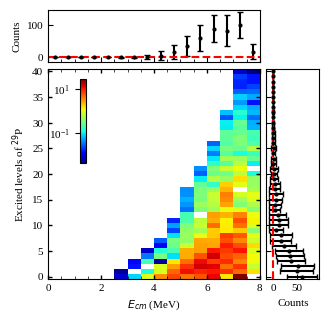

In [19]:
x_bins = 16
y_bins = max_levels + 1
x_min, x_max = 0.0, 8.0
y_min, y_max = -0.5, max_levels + 0.5

# ビンの境界を定義
x_edges = np.linspace(x_min, x_max, x_bins + 1)
y_edges = np.linspace(y_min, y_max, y_bins + 1)

# 平均ヒストグラムとプロジェクションを計算
main_hist_avg, main_x_projections, main_y_projections = compute_average_histogram(f'yield/{max_levels}/high_*.txt', x_edges, y_edges)
sub_hist_avg, sub_x_projections, sub_y_projections = compute_average_histogram(f'yield/{max_levels}/bg_*.txt', x_edges, y_edges)

# 差し引きしたヒストグラムを計算
diff_hist = main_hist_avg - (sub_hist_avg * constant_si26ap.bg_factor)

# Xプロジェクションの平均値と標準偏差を計算
main_x_proj_mean = np.mean(main_x_projections, axis=0)
main_x_proj_std = np.std(main_x_projections, axis=0)
main_x_proj_sqrt = np.sqrt(main_x_proj_mean)
sub_x_proj_mean = np.mean(sub_x_projections, axis=0)
sub_x_proj_std = np.std(sub_x_projections, axis=0)
sub_x_proj_sqrt = np.sqrt(sub_x_proj_mean)
diff_x_proj_mean = main_x_proj_mean - (sub_x_proj_mean * constant_si26ap.bg_factor)
diff_x_proj_std = np.sqrt(main_x_proj_std**2 + (sub_x_proj_std * constant_si26ap.bg_factor)**2)  # 差の標準偏差
diff_x_proj_sqrt = np.sqrt(main_x_proj_sqrt**2 + (sub_x_proj_sqrt * constant_si26ap.bg_factor)**2)  # 差の標準偏差
diff_x_proj_err = np.sqrt(diff_x_proj_std**2 + diff_x_proj_sqrt**2)  # 差の標準偏差

# Yプロジェクションの平均値と標準偏差を計算
main_y_proj_mean = np.mean(main_y_projections, axis=0)
main_y_proj_std = np.std(main_y_projections, axis=0)
main_y_proj_sqrt = np.sqrt(main_y_proj_mean)
sub_y_proj_mean = np.mean(sub_y_projections, axis=0)
sub_y_proj_std = np.std(sub_y_projections, axis=0)
sub_y_proj_sqrt = np.sqrt(sub_y_proj_mean)
diff_y_proj_mean = main_y_proj_mean - (sub_y_proj_mean * constant_si26ap.bg_factor)
diff_y_proj_std = np.sqrt(main_y_proj_std**2 + (sub_y_proj_std * constant_si26ap.bg_factor)**2)
diff_y_proj_sqrt = np.sqrt(main_y_proj_sqrt**2 + (sub_y_proj_sqrt * constant_si26ap.bg_factor)**2)
diff_y_proj_err = np.sqrt(diff_y_proj_std**2 + diff_y_proj_sqrt**2)

# ヒストグラムを描画
plot_histograms(diff_hist, x_edges, y_edges,
                diff_x_proj_mean, diff_x_proj_err,
                diff_y_proj_mean, diff_y_proj_err)

## cross section

In [20]:
iremove = 9
x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
x_bin_centers = remove_elements(x_bin_centers, iremove)

### solid angle

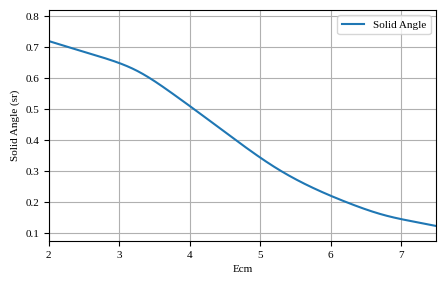

In [21]:
solid_angle_root_path = "/home/okawa/art_analysis/develop/develop/rootfile/solid/si26.hist.root"
solid_spline = create_spline(solid_angle_root_path, "Ecm")
solid_array = evaluate_spline(solid_spline, x_bin_centers)
solid_array = np.array(solid_array)

if solid_spline and do_debug:
    # ヒストグラムの範囲を取得
    x_min = solid_spline.GetXmin()
    x_max = solid_spline.GetXmax()

    # プロットするxの範囲を定義
    num_points = 1000
    x_values = np.linspace(x_min, x_max, num_points)

    # 補間値を計算
    y_values = evaluate_spline(solid_spline, x_values)

    # matplotlibでプロット
    plt.figure(figsize=(5, 3))
    plt.plot(x_values, y_values, label="Solid Angle")
    plt.xlim(2.0, 7.5)  # x軸の範囲を0から5に設定
    plt.xlabel("Ecm")
    plt.ylabel("Solid Angle (sr)")
    plt.legend()
    plt.grid(True)
    plt.show()

### effective thickenss

calculate effective thickness unit: /cm2


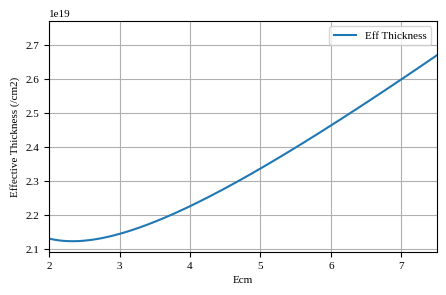

In [22]:
eff_spline = create_effthickness_spline()
eff_array = evaluate_effthickness(eff_spline, x_bin_centers)
eff_array = np.array(eff_array)

if eff_spline and do_debug:
    # ヒストグラムの範囲を取得
    x_min = 1.0
    x_max = 8.0

    # プロットするxの範囲を定義
    num_points = 1000
    x_values = np.linspace(x_min, x_max, num_points)

    # 補間値を計算
    y_values = evaluate_effthickness(eff_spline, x_values)

    # matplotlibでプロット
    plt.figure(figsize=(5, 3))
    plt.plot(x_values, y_values, label="Eff Thickness")
    plt.xlim(2.0, 7.5)  # x軸の範囲を0から5に設定
    plt.xlabel("Ecm")
    plt.ylabel("Effective Thickness (/cm2)")
    plt.legend()
    plt.grid(True)

### get syserror object

In [23]:
syserror_rootpath = "hist/syserror/syserror.root"
ecm_syserr_gr = get_slice_tgraph(syserror_rootpath, "Ecm", 0.5, 1.0, 1.0)
position_syserr_gr = get_slice_tgraph(syserror_rootpath, "Position", 30.0, 50.0, 50.0)

In [24]:
test_x_bins = 16
test_x_min, x_max = 0.0, 8.0
test_x_edges = np.linspace(x_min, x_max, x_bins + 1)
test_x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
for ecm in test_x_bin_centers:
    ecm_sigma = abs(ecm_syserr_gr.Eval(ecm))
    print(f"{ecm}: {ecm_sigma}")

0.25: 0.8518603265992531
0.75: 0.6959139720303528
1.25: 0.5399676174614525
1.75: 0.3840212628925521
2.25: 0.3106450403840907
2.75: 0.3027276903025209
3.25: 0.3063070039585142
3.75: 0.29961696067867916
4.25: 0.2855377061783317
4.75: 0.2593590079715275
5.25: 0.23691880250641795
5.75: 0.21564066175507987
6.25: 0.1980220918554955
6.75: 0.18311679515694212
7.25: 0.16654348104181596
7.75: 0.14922353571234878


In [25]:
ecm_err_array = []
solid_err_array = []
eff_err_array = []

for i, ecm in enumerate(x_bin_centers):
    ecm_sigma = abs(ecm_syserr_gr.Eval(ecm))
    ecm_err_array.append(ecm_sigma)
    solid_sigma = abs(ecm_sigma * solid_spline.Derivative(ecm))
    solid_err_array.append(solid_sigma)
    eff_sigma = abs(ecm_sigma * eff_spline.Derivative(ecm))
    eff_err_array.append(eff_sigma)

    if do_debug:
        print(f"{ecm:.2f}, {ecm_sigma:.2f}, {solid_array[i]:.2f}, {solid_sigma:.2f}, {eff_array[i]:.2e}, {eff_sigma:.2e}")

ecm_err_array = np.array(ecm_err_array)
solid_err_array = np.array(solid_err_array)
eff_err_array = np.array(eff_err_array)

4.75, 0.26, 0.38, 0.04, 2.31e+19, 3.02e+17
5.25, 0.24, 0.31, 0.03, 2.37e+19, 2.93e+17
5.75, 0.22, 0.25, 0.02, 2.43e+19, 2.80e+17
6.25, 0.20, 0.20, 0.02, 2.50e+19, 2.66e+17
6.75, 0.18, 0.16, 0.01, 2.57e+19, 2.52e+17
7.25, 0.17, 0.13, 0.01, 2.63e+19, 2.34e+17


### yield and error

In [26]:
phys_yield_array = main_x_proj_mean
phys_yield_array = remove_elements(phys_yield_array, iremove)
phys_yield_stat_array = np.sqrt(phys_yield_array)
phys_yield_modelsys_array = main_x_proj_std
phys_yield_modelsys_array = remove_elements(phys_yield_modelsys_array, iremove)

bg_yield_array = sub_x_proj_mean
bg_yield_array = remove_elements(bg_yield_array, iremove)
bg_yield_stat_array = np.sqrt(bg_yield_array)
bg_yield_modelsys_array = sub_x_proj_std
bg_yield_modelsys_array = remove_elements(bg_yield_modelsys_array, iremove)

subtracted_yield_array = phys_yield_array - (bg_yield_array * constant_si26ap.bg_factor)
print(np.sum(subtracted_yield_array))
subtracted_yield_stat_array = np.sqrt(phys_yield_stat_array**2 + (bg_yield_stat_array * constant_si26ap.bg_factor)**2)
subtracted_yield_modelsys_array = np.sqrt(phys_yield_modelsys_array**2 + (bg_yield_modelsys_array * constant_si26ap.bg_factor)**2)

381.64506000000006


### cross section

formula

```math
\sigma_{exp} = \frac{Y_{sub}(E)}{N_{beam}\cdot n_{eff}(E)\cdot \Delta\Omega (E) / 4\pi}
```

error, treat all errors are independent

```math
\begin{align*}
d\sigma_{exp} &= d\sigma_{Y} + d\sigma_{N} + d\sigma_{n} + d\sigma_{\Delta\Omega} \\
&= \sigma_{exp}\sqrt{\left(\frac{dY}{Y}\right)^2 + \left(\frac{dN}{N}\right)^2 + \left(\frac{dn}{n}\right)^2 + \left(\frac{d\Delta\Omega}{\Delta\Omega}\right)^2} \\
&= \sigma_{exp}\sqrt{\left(\frac{dY}{Y}\right)^2 + \left(\frac{\sqrt{N}}{N}\right)^2 + \left(\frac{1}{n}\frac{dn}{dE}dE\right)^2 + \left(\frac{1}{\Omega}\frac{d\Delta\Omega}{dE}dE\right)^2}
\end{align*}
```

```math
dY = \sqrt{dY_{model}^2 + dY_{stat}^2}
```

In [27]:
cs_array = subtracted_yield_array / (solid_array * eff_array)
cs_array = (4.0 * np.pi * 1.0e+3 *constant_si26ap.cm2tobarn / constant_si26ap.beam_num) * cs_array

In [28]:
cs_modelerr_array = cs_array * subtracted_yield_modelsys_array / subtracted_yield_array
cs_staterr_array = cs_array * subtracted_yield_stat_array / subtracted_yield_array
cs_Nerr_array = cs_array * np.sqrt(constant_si26ap.beam_num) / constant_si26ap.beam_num
cs_thickerr_array = cs_array * eff_err_array / eff_array
cs_soliderr_array = cs_array * solid_err_array / solid_array

cs_total_err_array = np.sqrt(cs_modelerr_array**2 + cs_staterr_array**2 + cs_Nerr_array**2 + cs_thickerr_array**2 + cs_soliderr_array**2)

In [29]:
print("   e     de       cs    d_cs   dYmod  dYstat      dN     dn  dOmeg  dOthe")
for i, ecm in enumerate(x_bin_centers):
    result = (
        f"{ecm:3.2f}, {ecm_err_array[i]:4.3f}, {cs_array[i]:7.3f}, "
        f"{cs_total_err_array[i]:6.3f}, "
        f"{cs_modelerr_array[i]:6.3f}, {cs_staterr_array[i]:6.3f}, "
        f"{cs_Nerr_array[i]:6.4f}, {cs_thickerr_array[i]:5.3f}, "
        f"{cs_soliderr_array[i]:5.3f}, "
        f"{np.sqrt(cs_Nerr_array[i]**2 + cs_thickerr_array[i]**2 + cs_soliderr_array[i]**2):5.3f}"
    )
    print(result)

   e     de       cs    d_cs   dYmod  dYstat      dN     dn  dOmeg  dOthe
4.75, 0.259,   7.416,  9.990,  6.832,  7.241, 0.0001, 0.097, 0.826, 0.832
5.25, 0.237,  19.019, 17.198, 11.620, 12.511, 0.0003, 0.236, 2.039, 2.053
5.75, 0.216,  39.281, 26.163, 17.448, 19.142, 0.0007, 0.452, 3.666, 3.694
6.25, 0.198,  71.141, 34.589, 22.184, 25.775, 0.0013, 0.757, 6.272, 6.318
6.75, 0.183,  79.805, 46.014, 29.008, 35.250, 0.0014, 0.785, 5.717, 5.770
7.25, 0.167, 110.633, 45.771, 28.889, 35.001, 0.0020, 0.984, 5.863, 5.945


In [30]:
popt, pcov = curve_fit(
    nonsmoker, x_bin_centers, cs_array, sigma=cs_total_err_array, absolute_sigma=True
)

a_fit = popt[0]
a_err_68 = np.sqrt(pcov[0, 0])
a_err_99 = 2.58 * a_err_68

# 結果を出力
print(f"best fit: {a_fit:.5f}")
print(f"68% error: +/- {a_err_68:.5f}, {a_fit - a_err_68:.5f} -- {a_fit + a_err_68:.5f}")
print(f"99% error: +/- {a_err_99:.5f}, {a_fit - a_err_99:.5f} -- {a_fit + a_err_99:.5f}")

best fit: 0.14107
68% error: +/- 0.03611, 0.10496 -- 0.17718
99% error: +/- 0.09316, 0.04791 -- 0.23424


In [31]:
with open(f"txt/present_{max_levels}.txt", "w") as f:
    f.write(f"# best fit {a_fit:.5f}\n")
    f.write(
        f"# 68% error: +/- {a_err_68:.5f}, {a_fit - a_err_68:.5f} -- {a_fit + a_err_68:.5f}\n"
    )
    f.write(
        f"# 99% error: +/- {a_err_99:.5f}, {a_fit - a_err_99:.5f} -- {a_fit + a_err_99:.5f}\n"
    )
    for i in range(len(x_bin_centers)):
        line = f"{x_bin_centers[i]}, {cs_array[i]}, {ecm_err_array[i]}, {cs_total_err_array[i]}"
        f.write(line + "\n")

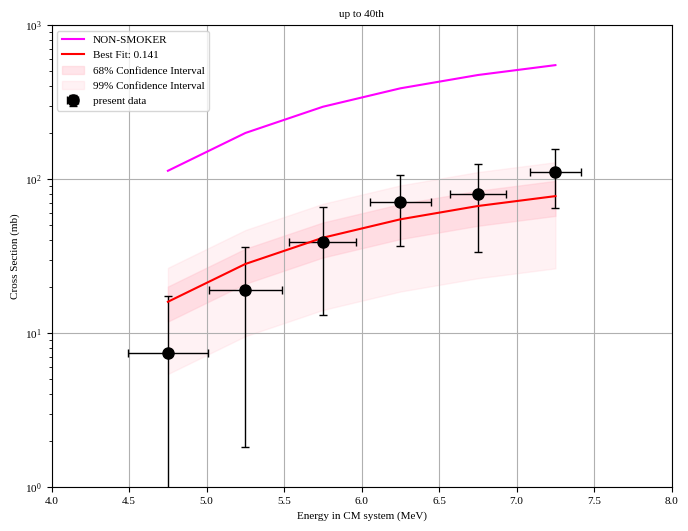

In [32]:
y_normal = nonsmoker(x_bin_centers, 1.0)
y_fit = nonsmoker(x_bin_centers, a_fit)

# 68%信頼区間の上限と下限を計算
y_upper_68 = nonsmoker(x_bin_centers, a_fit + a_err_68)
y_lower_68 = nonsmoker(x_bin_centers, a_fit - a_err_68)

# 99%信頼区間の上限と下限を計算
y_upper_99 = nonsmoker(x_bin_centers, a_fit + a_err_99)
y_lower_99 = nonsmoker(x_bin_centers, a_fit - a_err_99)

plt.figure(figsize=(8, 6))
plt.errorbar(
    x_bin_centers,
    cs_array,
    xerr=ecm_err_array,
    yerr=cs_total_err_array,
    marker="o",
    color="black",
    ecolor="black",
    linestyle="none",
    elinewidth=1,
    markersize=8,
    capsize=3,
    label="present data",
)

plt.plot(x_bin_centers, y_normal, "-", label=f"NON-SMOKER", color="magenta")
plt.plot(x_bin_centers, y_fit, "-", label=f"Best Fit: {a_fit:.3f}", color="red")

# 68%信頼区間を透明な青色で描画
plt.fill_between(
    x_bin_centers,
    y_lower_68,
    y_upper_68,
    color="pink",
    alpha=0.4,
    label="68% Confidence Interval",
)

# 99%信頼区間をピンク色で描画
plt.fill_between(
    x_bin_centers,
    y_lower_99,
    y_upper_99,
    color="pink",
    alpha=0.2,
    label="99% Confidence Interval",
)

plt.xlim(4.0, 8.0)
plt.ylim(1.0, 1.0e+3)
plt.title(f"up to {max_levels}th")
plt.xlabel("Energy in CM system (MeV)")  # x軸のラベル
plt.ylabel("Cross Section (mb)")  # y軸のラベル
plt.yscale("log")
plt.legend(loc="upper left")
plt.grid(True)  # グリッドの表示
plt.savefig(
    f"figure/cs/cross_section_{max_levels}_2p.png",
    format="png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()  # グラフの表示

In [33]:
## NumPy配列に変換
#array = np.array(main_x_projections)
#
## 2列目 (インデックス1) を取得
#column = array[:, 13]
#mean = np.mean(column)
#std_dev = np.std(column)
#plt.hist(column, bins=30, edgecolor="black", color="blue", alpha=0.2)
#plt.axvline(
#    mean, color="red", linestyle="dashed", linewidth=1, label=f"Mean: {mean:.2f}"
#)
#plt.axvline(
#    mean + std_dev,
#    color="green",
#    linestyle="dotted",
#    linewidth=1,
#    label=f"Std Dev: ±{std_dev:.2f}",
#)
#plt.axvline(mean - std_dev, color="green", linestyle="dotted", linewidth=1)
#
## 平均値と標準偏差のテキスト表示
#plt.text(mean+0.5, plt.ylim()[1] * 0.8, f"mean = {mean:.2f}\nsigma = {std_dev:.2f}", color="red")
#
#
#plt.xlabel("Value")
#plt.ylabel("Frequency")
#plt.title("1000 samples, phys yield Ecm = 6.75")
#plt.savefig(
#    f"figure/yield/error/ecm_6.75_{max_levels}th_1000samples.png",
#    format="png",
#    dpi=300,
#    bbox_inches="tight",
#)
#plt.show()